# Figure 3 – High-throughput prime editing sensor screens identify pathogenic TP53 variants

## Figure 3b

The number of significantly enriching or depleting pegRNAs (FDR < .05) as a function of the minimum correct editing percentage threshold at Day 34 in untreated (blue) or Nutlin-treated (red) conditions. 

In [66]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
#import re
import scipy.stats
import regex as re
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statannot
plt.rc('font', family='Helvetica')

import warnings
warnings.filterwarnings('ignore')


In [67]:
#reading the MAGeCK results into a dictionary
#and also reading in information about correct editing percentage

#loading in the data
p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')


#loading in the merged replicates to boost confidence on sensor
fp = "crispresso_replicates_merged"
reorder = []
conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']
for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)

cp_dict2 = dict(zip(conditions, reorder))
samps = list(cp_dict2.keys())[1:]


#reading in mageck
fp = './MAGeCK analysis'
files = os.listdir(fp)
files = sorted([f for f in files if f[-3:]=='txt'])

dfs = []
for i,f in enumerate(files):
    df = pd.read_csv(fp + '/' + f, sep='\t')

    #ensure naming is correct
    assert f[:3]==samps[i][:3]

    #reorder the pegs...
    df = df.rename(columns = {'sgrna':'peg_id'})
    df_merge = pd.merge(p53_filtered, df, how='left', on='peg_id')

    #also add in merge of cp_dict?

    dfs.append(df_merge)


#perform thresholding of control_mean counts (filtering out pegRNAs with below 10 control counts mean)
#differences in counts because of normalization
#going to do it for one and apply it to all...

control_mean_threshold = 10

#d16
dd = dfs[0]
dd = dd[dd['control_mean']>=control_mean_threshold]
pegs_above_thres = dd['peg_id']

dfs2 = []
for i in dfs:
    dfs2.append(i[i['peg_id'].isin(pegs_above_thres)])


assert list(dfs2[0]['peg_id']) == list(dfs2[1]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[2]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[3]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[4]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[5]['peg_id']) 

mageck_dict = dict(zip(samps, dfs2))



In [40]:
sample = 'D34'
counts_threshold=10 #minimum number of sensor reads for inclusion
corr_perc_max = 100

cps = np.linspace(0,50,51)
#cps = np.linspace(0,50,201)


num_signif_enriched_untreated = []
for corr_perc_min in cps:
    bb = mageck_dict[sample].copy()
    bb = bb.replace(0,1e-5) #for the log FDR calculation
    bb['-log10(FDR)']=-np.log10(bb['FDR'])
    bb['FDR_below_.05'] = bb['FDR']<.05

    d34 = cp_dict2[sample]
    d34 = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]
    p = d34[(d34['corr_perc_backsub']>=corr_perc_min) & (d34['corr_perc_backsub']<=corr_perc_max)]

    bb = pd.merge(bb, p, on='peg_id')
    #s = bb[(bb['LFC']>=2) & (bb['FDR_below_.05']==True)]
    s = bb[(bb['FDR_below_.05']==True)]

    num_signif_enriched_untreated.append(len(s))

sample = 'D34-NUT'
counts_threshold=10 #minimum number of sensor reads for inclusion
corr_perc_max = 100

num_signif_enriched_nutlin = []
for corr_perc_min in cps:
    bb = mageck_dict[sample].copy()
    bb = bb.replace(0,1e-5) #for the log FDR calculation
    bb['-log10(FDR)']=-np.log10(bb['FDR'])
    bb['FDR_below_.05'] = bb['FDR']<.05

    d34 = cp_dict2[sample]
    d34 = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]
    p = d34[(d34['corr_perc_backsub']>=corr_perc_min) & (d34['corr_perc_backsub']<=corr_perc_max)]

    bb = pd.merge(bb, p, on='peg_id')
    #s = bb[(bb['LFC']>=2) & (bb['FDR_below_.05']==True)]
    s = bb[(bb['FDR_below_.05']==True)]
    num_signif_enriched_nutlin.append(len(s))


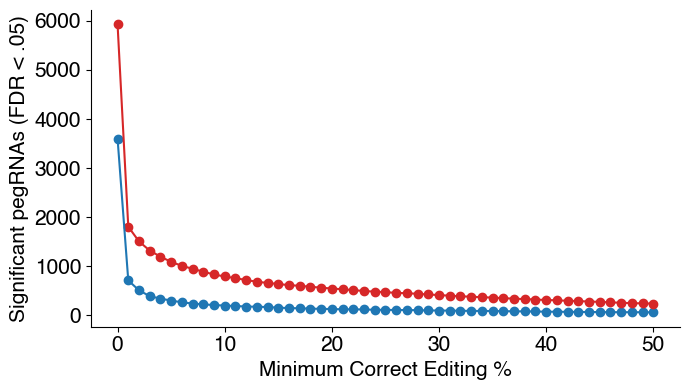

In [64]:
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(cps, num_signif_enriched_untreated, label='Untreated', color='tab:blue')
ax.scatter(cps, num_signif_enriched_nutlin, label='Nutlin', color='tab:red')
ax.plot(cps, num_signif_enriched_untreated, color='tab:blue')
ax.plot(cps, num_signif_enriched_nutlin, color='tab:red')

ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.legend(fontsize=15)

ax.set_ylabel('Significant pegRNAs (FDR < .05)', fontsize=15)
ax.set_xlabel('Minimum Correct Editing %', fontsize=15)

fig.tight_layout()
#fig.savefig('fig3b.pdf')

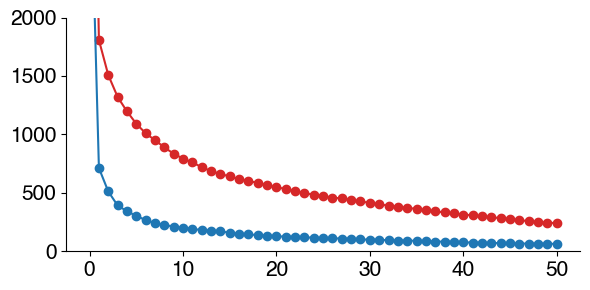

In [65]:
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(cps, num_signif_enriched_untreated, label='Untreated', color='tab:blue')
ax.scatter(cps, num_signif_enriched_nutlin, label='Nutlin', color='tab:red')
ax.plot(cps, num_signif_enriched_untreated, color='tab:blue')
ax.plot(cps, num_signif_enriched_nutlin, color='tab:red')

ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.legend(fontsize=15)

#ax.set_ylabel('Significantly Enriched/Depleted pegRNAs\n(FDR < .05)', fontsize=15)
#ax.set_xlabel('Minimum Correct Editing %', fontsize=15)

ax.set_ylim(0,2000)
fig.tight_layout()
#fig.savefig('3b_inset.pdf')

## Figure 3c

The LFC of each pegRNA ≥ 10% editing with at least 10 sensor reads at Day 34 relative to Day 4 in the untreated condition, with pegRNAs colored by editing efficiency. 

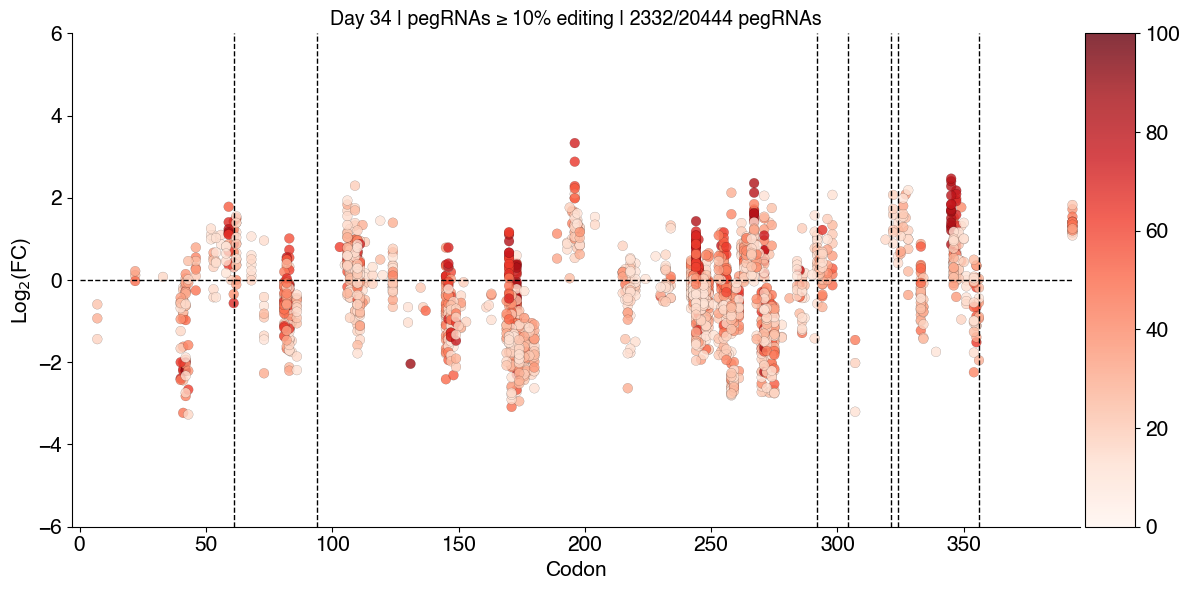

In [43]:
sample = 'D34'
counts_threshold=10 #minimum number of sensor reads for inclusion
corr_perc_min = 10
corr_perc_max = 100


fig, ax = plt.subplots(figsize=(12,6))

bb = mageck_dict[sample].copy()
bb = bb.replace(0,1e-5) #for the log FDR calculation
bb['-log10(FDR)']=-np.log10(bb['FDR'])
bb['FDR_below_.05'] = bb['FDR']<.05

d34 = cp_dict2[sample]
d34 = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]
p = d34[(d34['corr_perc_backsub']>=corr_perc_min) & (d34['corr_perc_backsub']<=corr_perc_max)]

bb = pd.merge(bb, p, on='peg_id')


g = ax.scatter(data = bb, x='codon', y='LFC', c='corr_perc_backsub', cmap='Reds', vmin=0, vmax=100, alpha=.8, s=50, edgecolor='black', linewidths=.1)
#plt.colorbar()

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)


fig.colorbar(g, cax=cax, orientation='vertical')

ax.plot([0,393],[0,0], linewidth=1, linestyle='dashed', color='black')
ax.set_title(f"Day 34 | pegRNAs ≥ {corr_perc_min}% editing | {len(bb)}/{len(d34)} pegRNAs", fontsize=14)
ax.set_ylim(-6,6)
ax.set_xlim(-3,396)
ax.set_ylabel("Log$_{2}$(FC)", fontsize=15)
ax.set_xlabel("Codon", fontsize=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
cax.tick_params(axis='both', which='major', labelsize=15)


#plotting domain lines

boundaries = [61,94,292,304,321,324,356]
for bound in boundaries:
    ax.plot([bound, bound],[-6,6], linewidth=1, linestyle='dashed', color='black')


fig.tight_layout()

## Figure 3d

The LFC of each pegRNA ≥ 10% editing with at least 10 sensor reads at Day 34 relative to Day 4 in the Nutlin-treated condition, with pegRNAs colored by editing efficiency. 

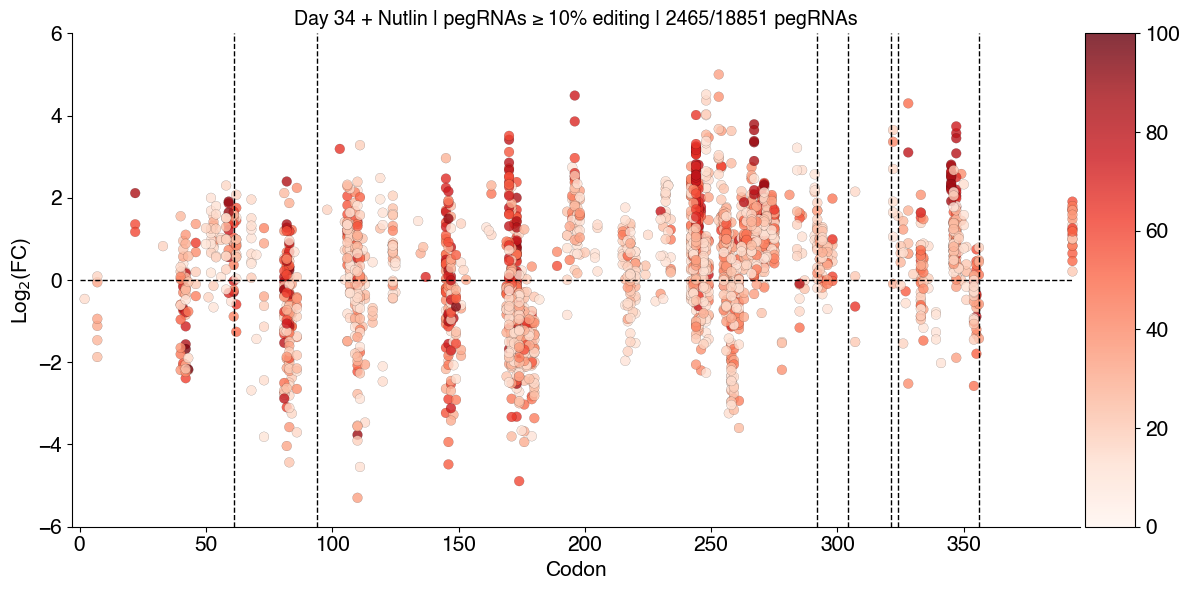

In [14]:
sample = 'D34-NUT'
counts_threshold=10
corr_perc_min = 10
corr_perc_max = 100


fig, ax = plt.subplots(figsize=(12,6))

bb = mageck_dict[sample].copy()
bb = bb.replace(0,1e-5) #for the log FDR calculation
bb['-log10(FDR)']=-np.log10(bb['FDR'])
bb['FDR_below_.05'] = bb['FDR']<.05

d34 = cp_dict2[sample]
d34 = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]
p = d34[(d34['corr_perc_backsub']>=corr_perc_min) & (d34['corr_perc_backsub']<=corr_perc_max)]

bb = pd.merge(bb, p, on='peg_id')


g = ax.scatter(data = bb, x='codon', y='LFC', c='corr_perc_backsub', cmap='Reds', vmin=0, vmax=100, alpha=.8, s=50, edgecolor='black', linewidths=.1)
#plt.colorbar()

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)


fig.colorbar(g, cax=cax, orientation='vertical')

ax.plot([0,393],[0,0], linewidth=1, linestyle='dashed', color='black')
ax.set_title(f"Day 34 + Nutlin | pegRNAs ≥ {corr_perc_min}% editing | {len(bb)}/{len(d34)} pegRNAs", fontsize=14)
ax.set_ylim(-6,6)
ax.set_xlim(-3,396)
ax.set_ylabel("Log$_{2}$(FC)", fontsize=15)
ax.set_xlabel("Codon", fontsize=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
cax.tick_params(axis='both', which='major', labelsize=15)


#plotting domain lines

boundaries = [61,94,292,304,321,324,356]
for bound in boundaries:
    ax.plot([bound, bound],[-6,6], linewidth=1, linestyle='dashed', color='black')


fig.tight_layout()

## Figure 3e

Plot (a), but with pegRNAs colored by variant type. Enriching pegRNAs with LFC ≥ 2 and FDR < .05 labeled. Blue = SNV, Green = INS, Purple = DEL, Gray = Silent.

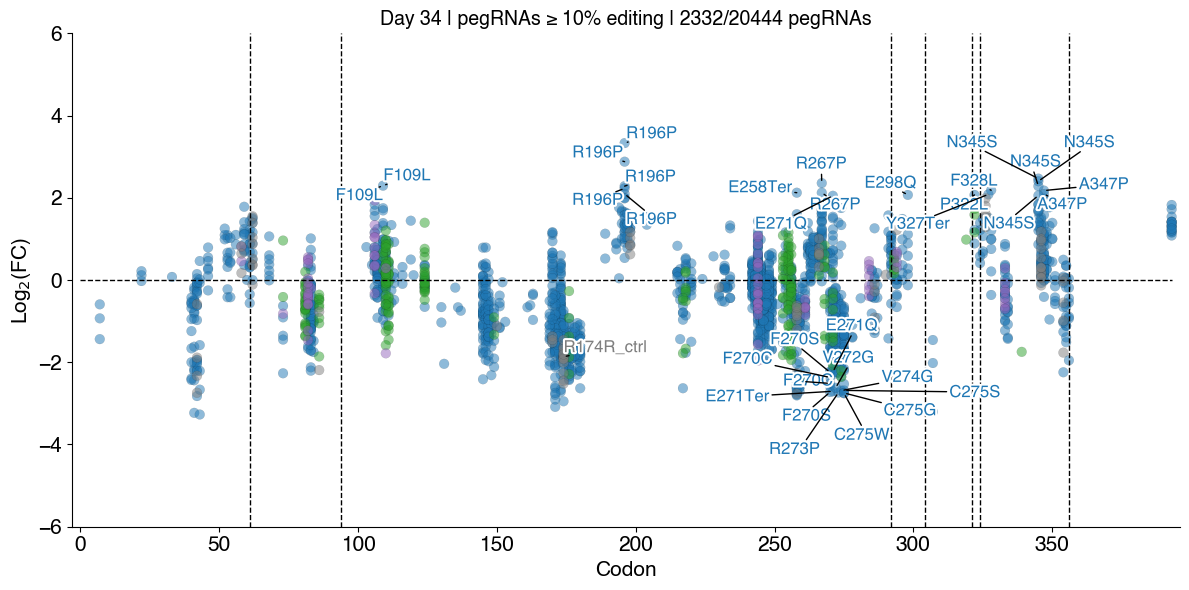

In [33]:
sample = 'D34'
counts_threshold=10
corr_perc_min = 10
corr_perc_max = 100


fig, ax = plt.subplots(figsize=(12,6))

bb = mageck_dict[sample].copy()
bb = bb.replace(0,1e-5) #for the log FDR calculation
bb['-log10(FDR)']=-np.log10(bb['FDR'])
bb['FDR_below_.05'] = bb['FDR']<.05

d34 = cp_dict2[sample]
d34 = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]
p = d34[(d34['corr_perc_backsub']>=corr_perc_min) & (d34['corr_perc_backsub']<=corr_perc_max)]

bb = pd.merge(bb, p, on='peg_id')


c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'tab:grey'}

#coloring based on SNV, INS, DEL, or silent
type_var = []
for i, val in enumerate(bb['variant_type']):
    s = bb['classification'][i]
    if s=='Silent':
        type_var.append('Silent')
    else:
        type_var.append(val)

bb['color'] = [c_dict[i] for i in type_var]


g = ax.scatter(data = bb, x='codon', y='LFC', c='color', alpha=.5, s=50, edgecolor='black', linewidths=.1)

ax.plot([0,393],[0,0], linewidth=1, linestyle='dashed', color='black')
ax.set_title(f"Day 34 | pegRNAs ≥ {corr_perc_min}% editing | {len(bb)}/{len(d34)} pegRNAs", fontsize=14)
ax.set_ylim(-6,6)
ax.set_xlim(-3,396)
ax.set_ylabel("Log$_{2}$(FC)", fontsize=15)
ax.set_xlabel("Codon", fontsize=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)


#plotting domain lines
boundaries = [61,94,292,304,321,324,356]
for bound in boundaries:
    ax.plot([bound, bound],[-6,6], linewidth=1, linestyle='dashed', color='black')


#pegRNA annotation
#text annotation code
cutoff = 2.
min_cutoff = -4

bbb1 = bb[bb['LFC']>=cutoff]

bbb2 = bb[bb['LFC']<=-.5]
bbb2 = bbb2[bbb2['FDR_below_.05']==True]

first_half = bb[bb['codon']<=160]
fh1 = first_half[first_half['LFC']>=2]

bb2 = pd.concat((bbb1, bbb2, fh1))

t = list(bb2['Gene'])
x=list(bb2['codon'])
y = list(bb2['LFC'])
#c = list(bb2['variant_type'])
c = list(bb2['color'])
#adjust_text(texts, x, y, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

#c_dict = {'SNV':'darkblue', 'INS':'darkgreen', 'DEL':'tab:purple', 'ONV':'grey'}
c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'tab:grey'}


texts = [ax.text(x[i], y[i], t[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))


fig.tight_layout()

## Figure 3f

Plot (b), but with pegRNAs colored by variant type. Selected enriching pegRNAs with FDR < .05 labeled. Depleting pegRNAs with FDR < .05 labeled. Blue = SNV, Green = INS, Purple = DEL, Gray = Silent.

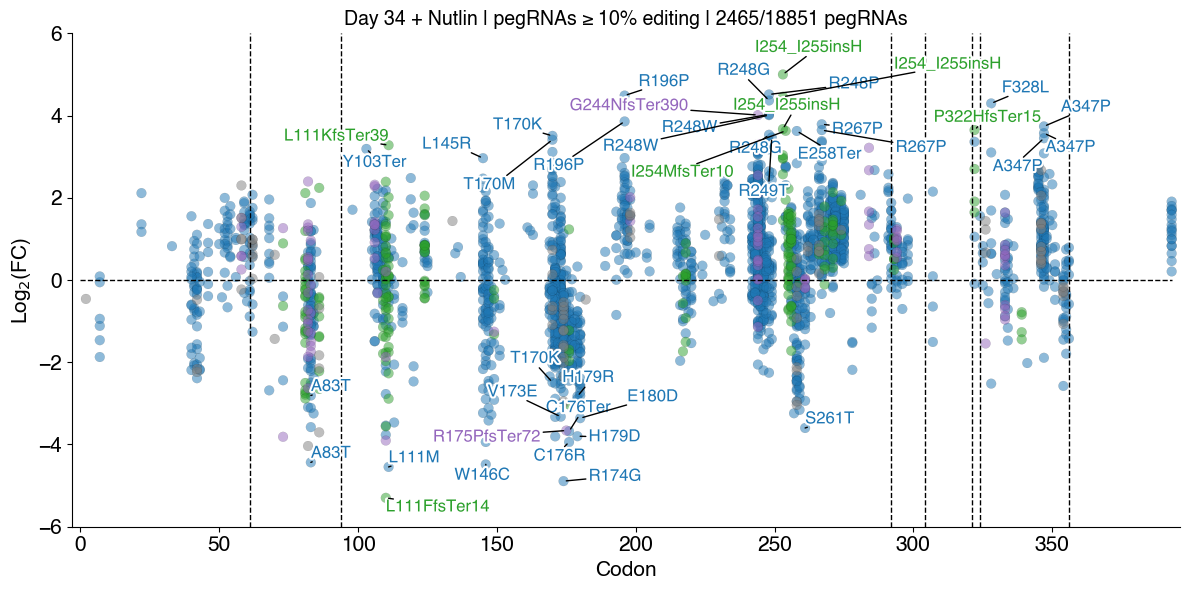

In [34]:
sample = 'D34-NUT'
counts_threshold=10
corr_perc_min = 10
corr_perc_max = 100


fig, ax = plt.subplots(figsize=(12,6))

bb = mageck_dict[sample].copy()
bb = bb.replace(0,1e-5) #for the log FDR calculation
bb['-log10(FDR)']=-np.log10(bb['FDR'])
bb['FDR_below_.05'] = bb['FDR']<.05

d34 = cp_dict2[sample]
d34 = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]
p = d34[(d34['corr_perc_backsub']>=corr_perc_min) & (d34['corr_perc_backsub']<=corr_perc_max)]

bb = pd.merge(bb, p, on='peg_id')

#c_dict = {'SNV':'darkblue', 'INS':'darkgreen', 'DEL':'tab:purple', 'ONV':'grey'}
c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'Silent':'tab:grey'}

#coloring based on SNV, INS, DEL, or silent
type_var = []
for i, val in enumerate(bb['variant_type']):
    s = bb['classification'][i]
    if s=='Silent':
        type_var.append('Silent')
    else:
        type_var.append(val)

bb['color'] = [c_dict[i] for i in type_var]


g = ax.scatter(data = bb, x='codon', y='LFC', c='color', alpha=.5, s=50, edgecolor='black', linewidths=.1)

ax.plot([0,393],[0,0], linewidth=1, linestyle='dashed', color='black')
ax.set_title(f"Day 34 + Nutlin | pegRNAs ≥ {corr_perc_min}% editing | {len(bb)}/{len(d34)} pegRNAs", fontsize=14)
ax.set_ylim(-6,6)
ax.set_xlim(-3,396)
ax.set_ylabel("Log$_{2}$(FC)", fontsize=15)
ax.set_xlabel("Codon", fontsize=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)


#plotting domain lines
boundaries = [61,94,292,304,321,324,356]
for bound in boundaries:
    ax.plot([bound, bound],[-6,6], linewidth=1, linestyle='dashed', color='black')


#pegRNA annotation
#text annotation code
cutoff = 3.4
min_cutoff = -4

bbb1 = bb[bb['LFC']>=cutoff]

bbb2 = bb[bb['LFC']<=-.5]
bbb2 = bbb2[bbb2['FDR_below_.05']==True]

first_half = bb[bb['codon']<=160]
fh1 = first_half[first_half['LFC']>=2.5]

bb2 = pd.concat((bbb1, bbb2, fh1))

t = list(bb2['Gene'])
x=list(bb2['codon'])
y = list(bb2['LFC'])
c = list(bb2['color'])
#adjust_text(texts, x, y, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

#c_dict = {'SNV':'darkblue', 'INS':'darkgreen', 'DEL':'tab:purple', 'ONV':'grey'}
c_dict = {'SNV':'tab:blue', 'INS':'tab:green', 'DEL':'tab:purple', 'ONV':'tab:grey'}

texts = [ax.text(x[i], y[i], t[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))


fig.tight_layout()

## Figure 3g

Box-plot of LFC in pegRNAs at Day 34 in Nutlin-treated condition separated by variant class for pegRNAs ≥ 10% editing. Statistics shown for t-test of independent samples with Bonferroni correction. * = p-value ≤ .05, ** = p-value ≤ .01, *** = p-value ≤ .001, **** = p-value ≤ .0001, ns = not significant (p-value > .05). 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Missense v.s. Nonsense: t-test independent samples with Bonferroni correction, P_val=2.996e-02 stat=-2.677e+00
Nonsense v.s. INS: t-test independent samples with Bonferroni correction, P_val=5.716e-02 stat=2.461e+00
Nonsense v.s. DEL: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=6.364e-01
Nonsense v.s. Silent: t-test independent samples with Bonferroni correction, P_val=2.895e-04 stat=4.031e+00


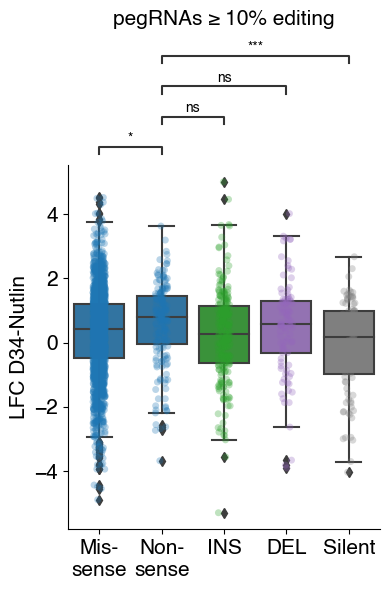

In [48]:
sample = 'D34-NUT'
bb = mageck_dict[sample].copy()
d34 = cp_dict2[sample]
counts_threshold=10
d34 = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]
merged = pd.merge(bb, d34, on='peg_id')

min_edit = 10

merged = merged[merged['corr_perc_backsub']>=min_edit]


mut = []
for idx, val in merged.iterrows():
    aa = val['HGVSp']
    type1 = val['variant_type']
    conseq = val['consequence']
    if conseq in ['Missense', 'Nonsense', 'Silent']:
        mut.append(conseq)
    else:
        mut.append(type1)


merged['Effect'] = mut

fig, ax = plt.subplots(figsize=(4,6))
#colors = ['darkblue', 'darkblue','darkgreen', 'tab:purple', 'grey']

colors = ['tab:blue', 'tab:blue', 'tab:green', 'tab:purple', 'tab:grey']

g = sns.boxplot(data=merged, x='Effect', y='LFC', ax=ax, palette=colors)
g1 = sns.stripplot(data=merged, x='Effect', y='LFC', ax=ax, alpha=.3, palette=colors)#edgecolor='black', linewidth=.5)

ax.set_xticklabels(['Mis-\nsense', 'Non-\nsense', 'INS', 'DEL', 'Silent'])
ax.set_xlabel('')
ax.set_ylabel('LFC D34-Nutlin', fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


statannot.add_stat_annotation(
    ax,
    data=merged,
    x='Effect',
    y='LFC',
    #hue=hue,
    box_pairs=[
        (("Nonsense"), ("Missense")),
        (("Nonsense"), ("INS")),
        (("Nonsense"), ("DEL")),
        (("Nonsense"), ("Silent"))
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)

ax.set_title(f'pegRNAs ≥ {min_edit}% editing\n\n\n\n\n\n', fontsize=15)
fig.tight_layout()

## Figure 3h

Box-plot of LFC in pegRNAs at Day 34 in Nutlin-treated condition separated by variant class for pegRNAs ≥ 20% editing. Statistics shown for t-test of independent samples with Bonferroni correction. * = p-value ≤ .05, ** = p-value ≤ .01, *** = p-value ≤ .001, **** = p-value ≤ .0001, ns = not significant (p-value > .05). 

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_20854/2675822210.py:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g1 = sns.stripplot(data=merged, x='Effect', y='LFC', ax=ax, alpha=.3, palette=colors)#edgecolor='black', linewidth=.5)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Missense v.s. Nonsense: t-test independent samples with Bonferroni correction, P_val=9.422e-03 stat=-3.047e+00
Nonsense v.s. INS: t-test independent samples with Bonferroni correction, P_val=2.487e-02 stat=2.763e+00
Nonsense v.s. DEL: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=7.751e-01
Nonsense v.s. Silent: t-test independent samples with Bonferroni correction, P_val=1.592e-03 stat=3.638e+00


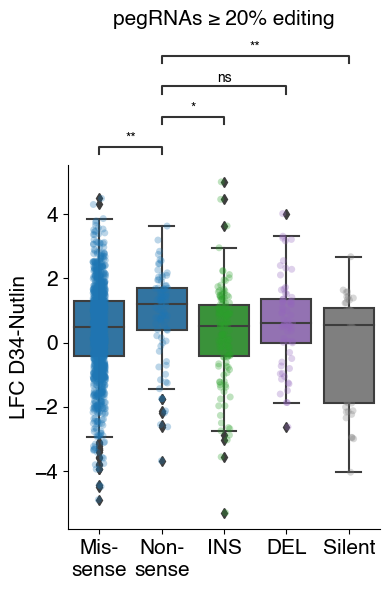

In [47]:
sample = 'D34-NUT'
bb = mageck_dict[sample].copy()
d34 = cp_dict2[sample]
counts_threshold=10
d34 = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]
merged = pd.merge(bb, d34, on='peg_id')

min_edit = 20

merged = merged[merged['corr_perc_backsub']>=min_edit]


mut = []
for idx, val in merged.iterrows():
    aa = val['HGVSp']
    type1 = val['variant_type']
    conseq = val['consequence']
    if conseq in ['Missense', 'Nonsense', 'Silent']:
        mut.append(conseq)
    else:
        mut.append(type1)


merged['Effect'] = mut

fig, ax = plt.subplots(figsize=(4,6))
colors = ['tab:blue', 'tab:blue', 'tab:green', 'tab:purple', 'tab:grey']

g = sns.boxplot(data=merged, x='Effect', y='LFC', ax=ax, palette=colors)
g1 = sns.stripplot(data=merged, x='Effect', y='LFC', ax=ax, alpha=.3, palette=colors)#edgecolor='black', linewidth=.5)

ax.set_xticklabels(['Mis-\nsense', 'Non-\nsense', 'INS', 'DEL', 'Silent'])
ax.set_xlabel('')
ax.set_ylabel('LFC D34-Nutlin', fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


statannot.add_stat_annotation(
    ax,
    data=merged,
    x='Effect',
    y='LFC',
    #hue=hue,
    box_pairs=[
        (("Nonsense"), ("Missense")),
        (("Nonsense"), ("INS")),
        (("Nonsense"), ("DEL")),
        (("Nonsense"), ("Silent"))
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)

ax.set_title(f'pegRNAs ≥ {min_edit}% editing\n\n\n\n\n\n', fontsize=15)
fig.tight_layout()

## Figure 3i
Box-plot of the LFC at Day 34 in the Nutlin-treated condition for pegRNAs ≥ 20% editing with annotated residue functions. 

Annotations acquired from: https://tp53.isb-cgc.org/get_tp53data#get_som_mut (Functional/structural data in TP53 with their annotations (includes validated polymorphisms))


In [4]:
#load in annotations
annots = pd.read_csv('existing_p53_variant_annotations/p53_mut_annotations.csv').fillna('none')
annots = annots.rename(columns={'c_description':'HGVSc'})


#and merged with information we have
sample = 'D34-NUT'
bb = mageck_dict[sample].copy()
d34 = cp_dict2[sample]
counts_threshold=10
d34 = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]

merged = pd.merge(bb, d34, on='peg_id')
merged_annots = pd.merge(merged, annots, on='HGVSc')


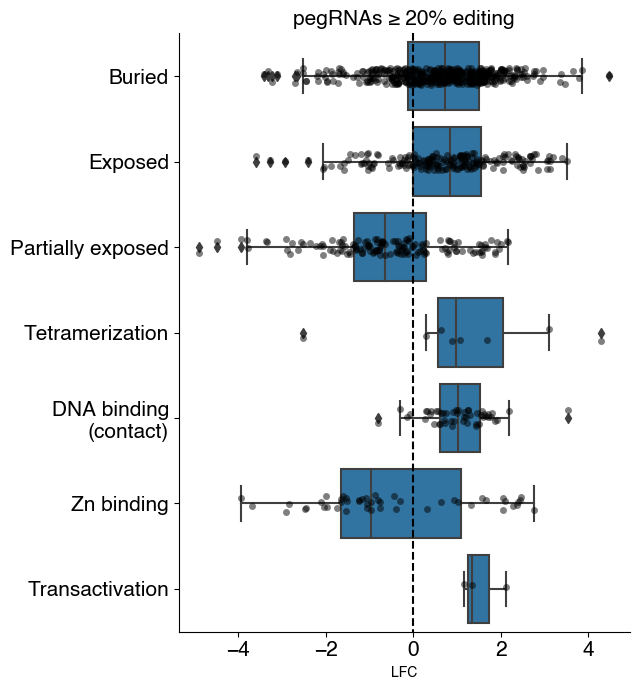

In [5]:
min_edit = 20

merged = merged_annots.copy()
merged = merged[merged['corr_perc_backsub']>=min_edit]

merged2 = merged.copy()
merged2 = merged2[merged2['Residue_function']!='none']

#merged2 = merged2[merged2['variant_type']=='SNV'] #not needed; filtration already done with merge

x = 'Residue_function'

order = ['Buried', 'Exposed', 'Partially exposed','Tetramerisation', 'DNA binding','Zn binding', 'Transactivation']

fig, ax = plt.subplots(figsize=(6.5,7))
g = sns.boxplot(data=merged2, y=x, x='LFC', ax=ax, order=order, color='tab:blue')
g1 = sns.stripplot(data=merged2, y=x, x='LFC', ax=ax, order=order, alpha=.5, color='black')

ax.plot([0,0],[-.5, 6.5], linestyle='dashed', color='black')

ax.set_ylabel('')

ax.set_yticklabels(['Buried', 'Exposed', 'Partially exposed','Tetramerization', 'DNA binding\n(contact)','Zn binding', 'Transactivation']
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title(f'pegRNAs ≥ {min_edit}% editing', fontsize=15)
fig.tight_layout()

## Figure 3j

Spearman correlation between LFC of SNV-generating variants and CADD score at Day 34 in untreated (blue) and Nutlin-treated (red) conditions at minimum correct editing thresholds spanning 0% to 65%.

CADD Scores generated using: https://cadd.gs.washington.edu/score


In [49]:
cadd = pd.read_csv('existing_p53_variant_annotations/CADD_scores.tsv.gz', compression='gzip', sep='\t', header=1)

In [50]:
#then merging CADD score dataframe with p53_filtered dataframe

idx_holder = []

for i, val in cadd.iterrows():
    s = val['Pos']
    ref = val['Ref']
    alt = val['Alt']

    sub = p53_filtered[(p53_filtered['start']==s) & (p53_filtered['ref_allele']==ref) & (p53_filtered['mut_allele']==alt)]
    l1 = list(sub['variant_index'])

    if len(l1)==0:
        idx_holder.append(None)

    else:
        idx_holder.append(l1[0])

cadd['variant_index'] = idx_holder

a_merge = pd.merge(p53_filtered, cadd, on='variant_index', how='right')

a_merge

,peg_id,variant_index,HGVSp,HGVSc,gene,chr,start,end,variant_type,classification,...,Freq1000bp,Rare1000bp,Sngl1000bp,Freq10000bp,Rare10000bp,Sngl10000bp,dbscSNV-ada_score,dbscSNV-rf_score,RawScore,PHRED
0,peg_13112,562.0,D393G,c.1178A>G,TP53,chr17,7572931.0,7572931.0,SNV,Observed SNV,...,1,8,62,24,53,577,NaN,NaN,3.377337,24.6
1,peg_13113,562.0,D393G,c.1178A>G,TP53,chr17,7572931.0,7572931.0,SNV,Observed SNV,...,1,8,62,24,53,577,NaN,NaN,3.377337,24.6
2,peg_13114,562.0,D393G,c.1178A>G,TP53,chr17,7572931.0,7572931.0,SNV,Observed SNV,...,1,8,62,24,53,577,NaN,NaN,3.377337,24.6
3,peg_13115,562.0,D393G,c.1178A>G,TP53,chr17,7572931.0,7572931.0,SNV,Observed SNV,...,1,8,62,24,53,577,NaN,NaN,3.377337,24.6
4,peg_13116,562.0,D393G,c.1178A>G,TP53,chr17,7572931.0,7572931.0,SNV,Observed SNV,...,1,8,62,24,53,577,NaN,NaN,3.377337,24.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20784,peg_18256,784.0,E3Ter,c.7G>T,TP53,chr17,7579906.0,7579906.0,SNV,Observed SNV,...,4,7,50,23,47,556,NaN,NaN,5.957412,35.0
20785,peg_18257,784.0,E3Ter,c.7G>T,TP53,chr17,7579906.0,7579906.0,SNV,Observed SNV,...,4,7,50,23,47,556,NaN,NaN,5.957412,35.0
20786,peg_18258,784.0,E3Ter,c.7G>T,TP53,chr17,7579906.0,7579906.0,SNV,Observed SNV,...,4,7,50,23,47,556,NaN,NaN,5.957412,35.0
20787,peg_18259,784.0,E3Ter,c.7G>T,TP53,chr17,7579906.0,7579906.0,SNV,Observed SNV,...,4,7,50,23,47,556,NaN,NaN,5.957412,35.0


In [51]:
#then merging this with LFC of variants
#SEE FIGURE 3a for loading in mageck_dict and cp_dict2
lfcs = [mageck_dict['D16']['peg_id']]
for key in mageck_dict.keys():
    lfc = np.array(mageck_dict[key]['LFC'])
    lfcs.append(lfc)

y = ['peg_id']+list(mageck_dict.keys())
df = pd.DataFrame(dict(zip(y, lfcs)))

sample = 'D34'
#do this for d34 correct editing
d34 = cp_dict2[sample]
lfc_corr = pd.merge(df, d34, on='peg_id')
merge2 = pd.merge(lfc_corr, a_merge, on='peg_id' , how='right')
counts_threshold=10
d34 = merge2[merge2['Reads_aligned_all_amplicons']>=counts_threshold]

#and d34 nut correct editing
sample = 'D34-NUT'
#do this for d34 correct editing
d34_NUT = cp_dict2[sample]
lfc_corr2 = pd.merge(df, d34_NUT, on='peg_id')
merge3 = pd.merge(lfc_corr2, a_merge, on='peg_id' , how='right')
counts_threshold=10
d34_NUT = merge3[merge3['Reads_aligned_all_amplicons']>=counts_threshold]


In [52]:
stats1 = []
stats2 = []
for x in range(65):
    corr_perc_min = x
    corr_perc_max = 100
    pegs_d34 = d34[(d34['corr_perc_backsub']>=corr_perc_min) & (d34['corr_perc_backsub']<=corr_perc_max)]

    pegs_d34_NUT = d34_NUT[(d34_NUT['corr_perc_backsub']>=corr_perc_min) & (d34_NUT['corr_perc_backsub']<=corr_perc_max)]
    
    x = pegs_d34['D34-NUT']
    x2 = pegs_d34_NUT['D34']
    y = pegs_d34['PHRED']
    y2 = pegs_d34_NUT['PHRED']

    jj = scipy.stats.spearmanr(x,y).statistic
    jj2 = scipy.stats.spearmanr(x2,y2).statistic

    stats1.append(jj)
    stats2.append(jj2)

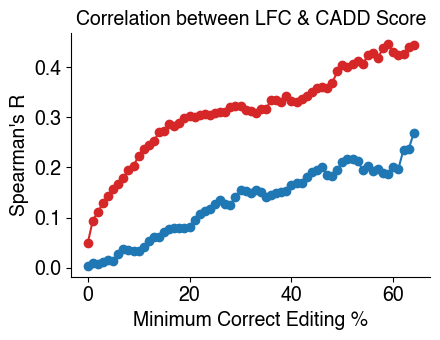

In [57]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
ax.scatter(range(65),stats1, color='tab:red', label='D34-Nutlin')
ax.scatter(range(65),stats2, color='tab:blue', label='D34')
ax.plot(range(65),stats1, color='tab:red')
ax.plot(range(65),stats2, color='tab:blue')
#ax.legend(loc='lower right', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel("Spearman's R", fontsize=14)
ax.set_title('Correlation between LFC & CADD Score', fontsize=14)

ax.set_xlabel("Minimum Correct Editing %", fontsize=14)
fig.tight_layout()
